# SETUP

In [388]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# Importing all required packages
import numpy as np
import pandas as pd

# Data viz lib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from plotly import graph_objects as go


In [389]:
dtafile = 'HCMST 2017 fresh sample for public sharing draft v1.1.dta'

df = pd.read_stata(dtafile)
df.head()


,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


In [392]:
df_anal = df[["w6_q32"]]
df = df.apply(lambda x: pd.factorize(x)[0])
df_anal.head()

,w6_q32
0,"Yes, an Internet dating or matchmaking site (l..."
1,"No, I did NOT meet [Partner Name] through the ..."
2,"Yes, an Internet dating or matchmaking site (l..."
3,"Yes, a social networking site (like Facebook o..."
4,"No, I did NOT meet [Partner Name] through the ..."


array([[<AxesSubplot: title={'center': 'w6_q32'}>]], dtype=object)

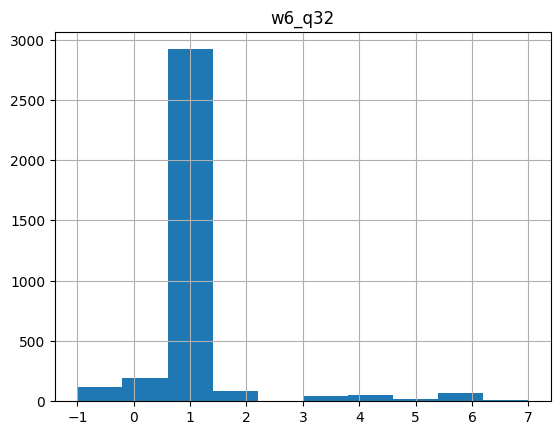

In [393]:
df.hist(column='w6_q32')

# CREATE CATEGORIES WITH AGE + FILL NAN VALUES

In [368]:
df['age_bin'] = pd.cut(df['ppage'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100], 
                              labels=['0-20', '20-30', '30-40', '40-50','50-60','60-70','70-80', '80-90','90-100'])

df = df.drop(['ppage', 'CASEID_NEW', 'CaseID','weight1', 'weight1_freqwt', 'weight2', 'weight1a', 'weight1a_freqwt', 'weight_combo', 'weight_combo_freqwt'], axis=1)
df = df.astype(str)

# filling with most common class
df = df.loc[:, df.isin([' ','NULL']).mean() < .6]
df = df.replace(['nan'], 'unknown')
df.head()

,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,Q3_Refused,...,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin
0,Qualified,9,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,unknown,...,no,no,no,White,no,12.0,14.0,12.0,14.0,20-30
1,Qualified,11,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married",unknown,unknown,1,unknown,...,no,no,yes,White,no,12.0,16.0,17.0,17.0,50-60
2,Qualified,7,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married",unknown,unknown,1,unknown,...,no,no,no,White,no,9.0,7.5,14.0,17.0,40-50
3,Qualified,5,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,unknown,...,no,no,no,White,no,16.0,12.0,12.0,12.0,20-30
4,Qualified,13,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married",unknown,unknown,1,unknown,...,no,yes,no,White,no,14.0,17.0,16.0,16.0,50-60


In [369]:
# First we will keep a copy of data
bank_cust_copy = df.copy()


In [370]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
bank_cust = df.apply(le.fit_transform)
bank_cust.head()

,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,Q3_Refused,...,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin
0,1,338,0,0,0,0,1,1,1,1,...,0,0,0,4,0,3,5,3,5,1
1,1,16,0,0,1,1,3,2,0,1,...,0,0,2,4,0,3,6,7,7,4
2,1,297,0,0,1,1,3,2,0,1,...,0,0,0,4,0,12,11,5,7,3
3,1,246,0,0,1,0,1,1,1,1,...,0,0,0,4,0,6,3,3,3,1
4,1,46,0,0,1,1,3,2,0,1,...,0,2,0,4,0,5,7,6,6,4


In [371]:
from kmodes.kmodes import KModes

# CAO METHOD

In [373]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 10, verbose=1)
    kmode.fit_predict(bank_cust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 283606.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 58, cost: 253564.0
Run 1, iteration: 2/100, moves: 0, cost: 253564.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 26, cost: 239534.0
Run 1, iteration: 2/100, moves: 0, cost: 239534.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 389, cost: 232087.0
Run 1, iteration: 2/100, moves: 65, cost: 232085.0
Run 1, iteration: 3/100, moves: 0, cost: 232085.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 391, cost: 229255.0
Run 1, iteration: 2/100, moves: 87, cost: 229160.0
Run 1, iteration: 3/100, moves: 41, cost: 229114.0
Run 1, iteration: 4/100, moves: 4, cost: 

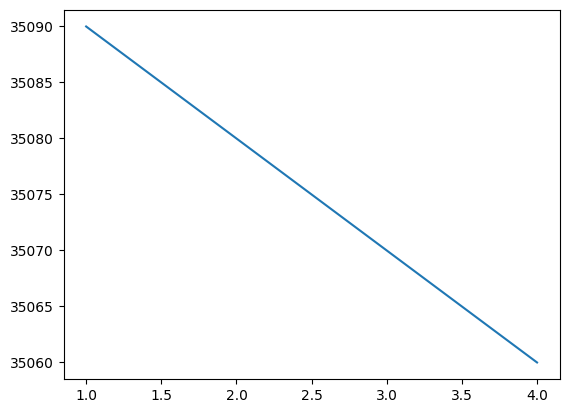

In [405]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [ ]:
km_cao = KModes(n_clusters=8, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1154, cost: 214532.0
Run 1, iteration: 2/100, moves: 1031, cost: 212514.0
Run 1, iteration: 3/100, moves: 328, cost: 211879.0
Run 1, iteration: 4/100, moves: 342, cost: 211052.0
Run 1, iteration: 5/100, moves: 408, cost: 209991.0
Run 1, iteration: 6/100, moves: 238, cost: 209984.0
Run 1, iteration: 7/100, moves: 0, cost: 209984.0


In [ ]:
bank_cust = bank_cust_copy.reset_index()
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([bank_cust, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)

In [ ]:
combinedDf.head()

,CaseID,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,...,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin,cluster_predicted
0,2,Qualified,9,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,12.0,14.0,12.0,14.0,20-30,6
1,3,Qualified,11,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,yes,White,no,12.0,16.0,17.0,17.0,50-60,0
2,5,Qualified,7,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,White,no,9.0,7.5,14.0,17.0,40-50,5
3,6,Qualified,5,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,16.0,12.0,12.0,12.0,20-30,6
4,7,Qualified,13,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,yes,no,White,no,14.0,17.0,16.0,16.0,50-60,5


In [ ]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]
cluster_2 = combinedDf[combinedDf['cluster_predicted'] == 2]
cluster_3 = combinedDf[combinedDf['cluster_predicted'] == 3]
cluster_4 = combinedDf[combinedDf['cluster_predicted'] == 4]
cluster_5 = combinedDf[combinedDf['cluster_predicted'] == 5]
cluster_6 = combinedDf[combinedDf['cluster_predicted'] == 6]
cluster_7 = combinedDf[combinedDf['cluster_predicted'] == 7]
cluster_8 = combinedDf[combinedDf['cluster_predicted'] == 8]

## Cluster infos

In [ ]:
cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1007 entries, 1 to 3509
Columns: 278 entries, CaseID to cluster_predicted
dtypes: object(277), uint16(1)
memory usage: 2.1+ MB


In [ ]:
cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 19 to 3508
Columns: 278 entries, CaseID to cluster_predicted
dtypes: object(277), uint16(1)
memory usage: 480.4+ KB


In [ ]:
cluster_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 15 to 3506
Columns: 278 entries, CaseID to cluster_predicted
dtypes: object(277), uint16(1)
memory usage: 519.5+ KB


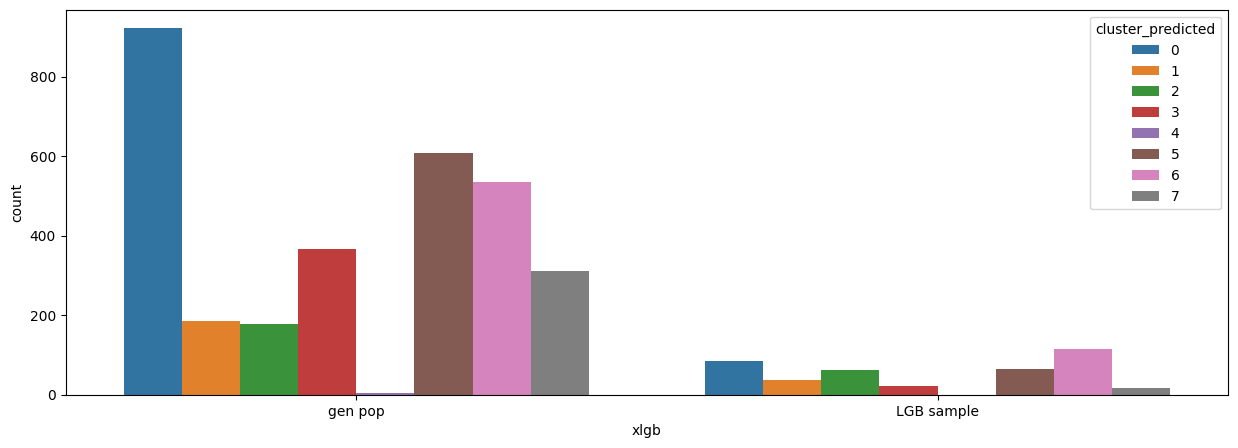

In [ ]:
# pop analysis
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['xlgb'],order=combinedDf['xlgb'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

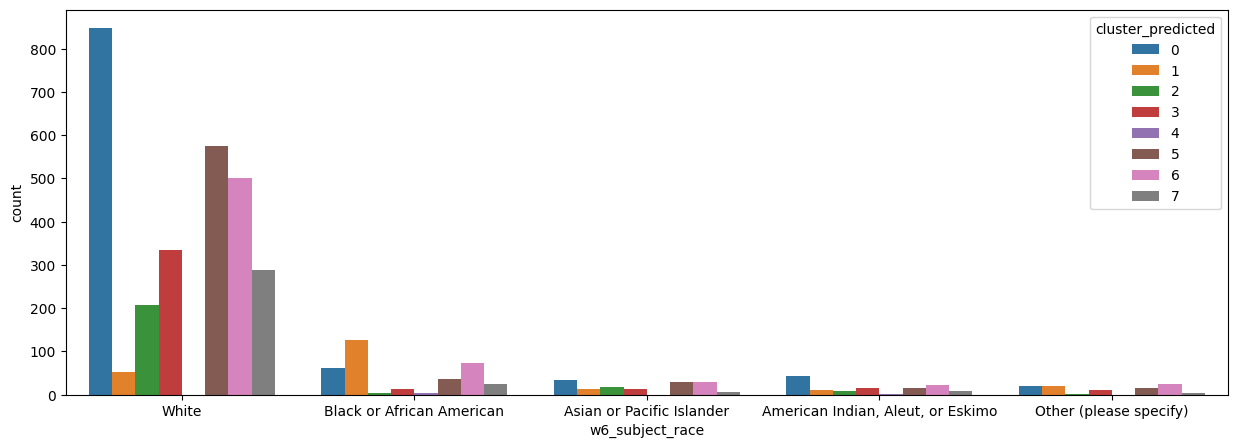

In [ ]:
# race analysis
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['w6_subject_race'],order=combinedDf['w6_subject_race'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

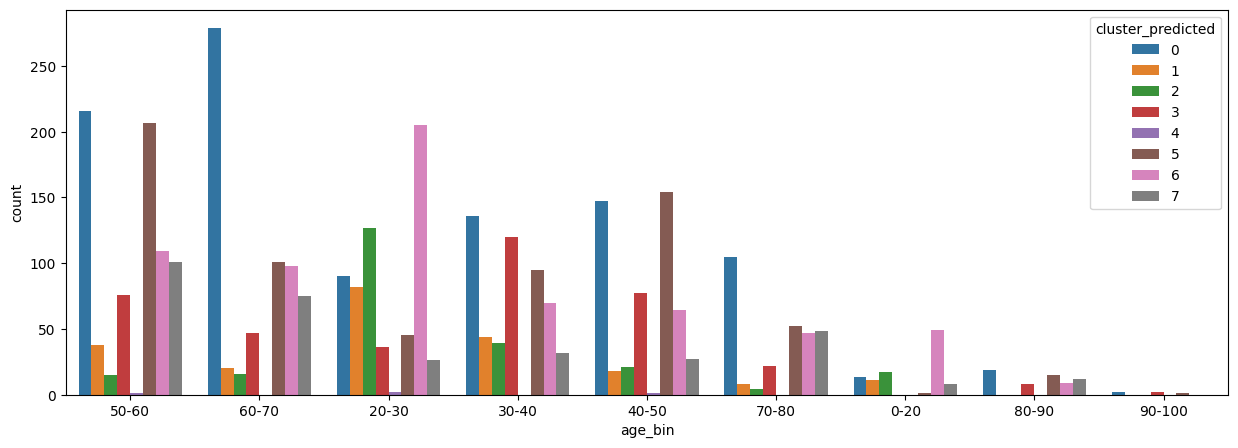

In [ ]:
# race analysis
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['age_bin'],order=combinedDf['age_bin'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

In [ ]:
combinedDf.head()

,CaseID,qflag,duration,speed_flag,consent,xlgb,S1,S2,S3,DOV_Branch,...,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed,age_bin,cluster_predicted
0,2,Qualified,9,Completed survey in over 2 minutes,"Yes, I agree to participate",LGB sample,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,12.0,14.0,12.0,14.0,20-30,6
1,3,Qualified,11,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,yes,White,no,12.0,16.0,17.0,17.0,50-60,0
2,5,Qualified,7,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,no,no,White,no,9.0,7.5,14.0,17.0,40-50,5
3,6,Qualified,5,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"No, I am not Married","No, I am single, with no boyfriend, no girlfri...",Yes,2,...,no,no,White,no,16.0,12.0,12.0,12.0,20-30,6
4,7,Qualified,13,Completed survey in over 2 minutes,"Yes, I agree to participate",gen pop,"Yes, I am Married","Yes, I have a sexual partner (boyfriend or gir...",Yes,1,...,yes,no,White,no,14.0,17.0,16.0,16.0,50-60,5


In [ ]:
inspect = []
for i in data_corr.columns[:15]:
    obs = pd.crosstab(data_corr['Churn'], data_corr[i])
    stat, pval, df, expected = chi2_contingency(obs)
    if pval < 0.05:
        inspect.append(i)

inspect

# HUANG METHOD

In [397]:
cost = []
for num_clusters in list(range(1,6)):
    kmode = KModes(n_clusters=num_clusters, init = "Huang", n_init = 5, verbose=1)
    kmode.fit_predict(bank_cust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 287115.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 287115.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 287115.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 287115.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 287115.0
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1048, cost: 265056.0
Run 1, iteration: 2/100, moves: 612, cost: 257109.0
Run 1, iteration: 3/100, moves: 22, cost: 257072.0
Run 1, iteration: 4/100, moves: 0, cost: 257072.0
Init: initializing centroids
Init: initial

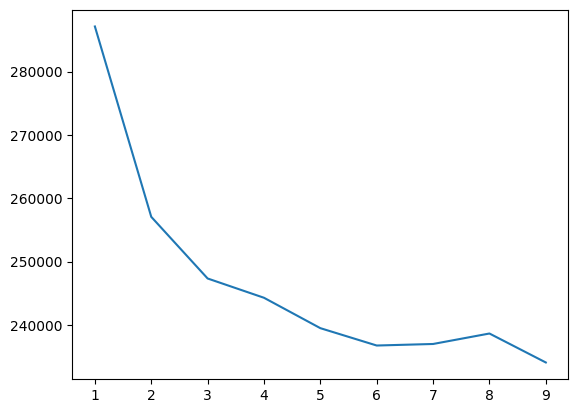

In [ ]:
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)

In [ ]:
km_huang = KModes(n_clusters=3, init = "huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1212, cost: 248794.0
Run 1, iteration: 2/100, moves: 253, cost: 248108.0
Run 1, iteration: 3/100, moves: 2, cost: 248108.0


In [394]:
bank_cust = bank_cust_copy.reset_index()
clustersDfH = pd.DataFrame(fitClusters_huang)
clustersDfH.columns = ['cluster_predicted']
combinedDfH = pd.concat([bank_cust, clustersDfH], axis = 1).reset_index()
combinedDfH = combinedDfH.drop(['index', 'level_0'], axis = 1)

In [395]:
combinedDfH = combinedDfH.rename(columns={'S2': 'do you see someone?', 'Q4': 'gender of the partner', 'Q17D':'What gender most attracted by (for men)', 'Q17C':'What gender most attracted by (for women)','Q26': 'same university', 'w6_q23': 'who earn more', 'Q23': 'who earned more in 2016'})

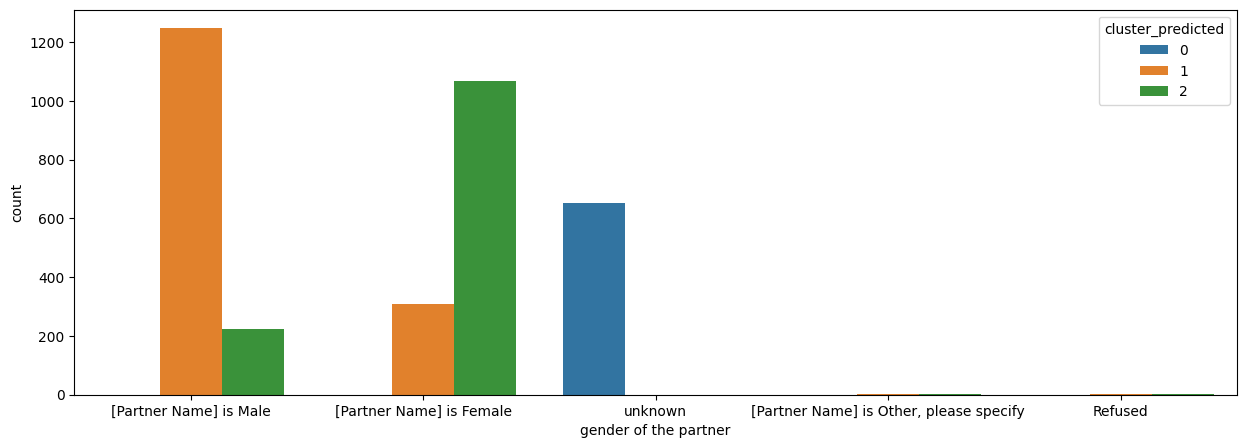

In [396]:
# race analysis
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDfH['gender of the partner'],order=combinedDfH['gender of the partner'].value_counts().index,hue=combinedDfH['cluster_predicted'])
plt.show()

# visu features importance

In [ ]:
combinedDfH = combinedDfH.apply(lambda x: pd.factorize(x)[0])
X = combinedDfH.drop("cluster_predicted", axis=1)
y = combinedDfH["cluster_predicted"]
X.head()
y.head()

0    0
1    1
2    2
3    0
4    1
Name: cluster_predicted, dtype: int64

In [ ]:
from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, X, y, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
CV F1 score for K-Prototypes clusters is 0.9449705935386611


[LightGBM] [Warning] Unknown parameter: colsample_by_tree


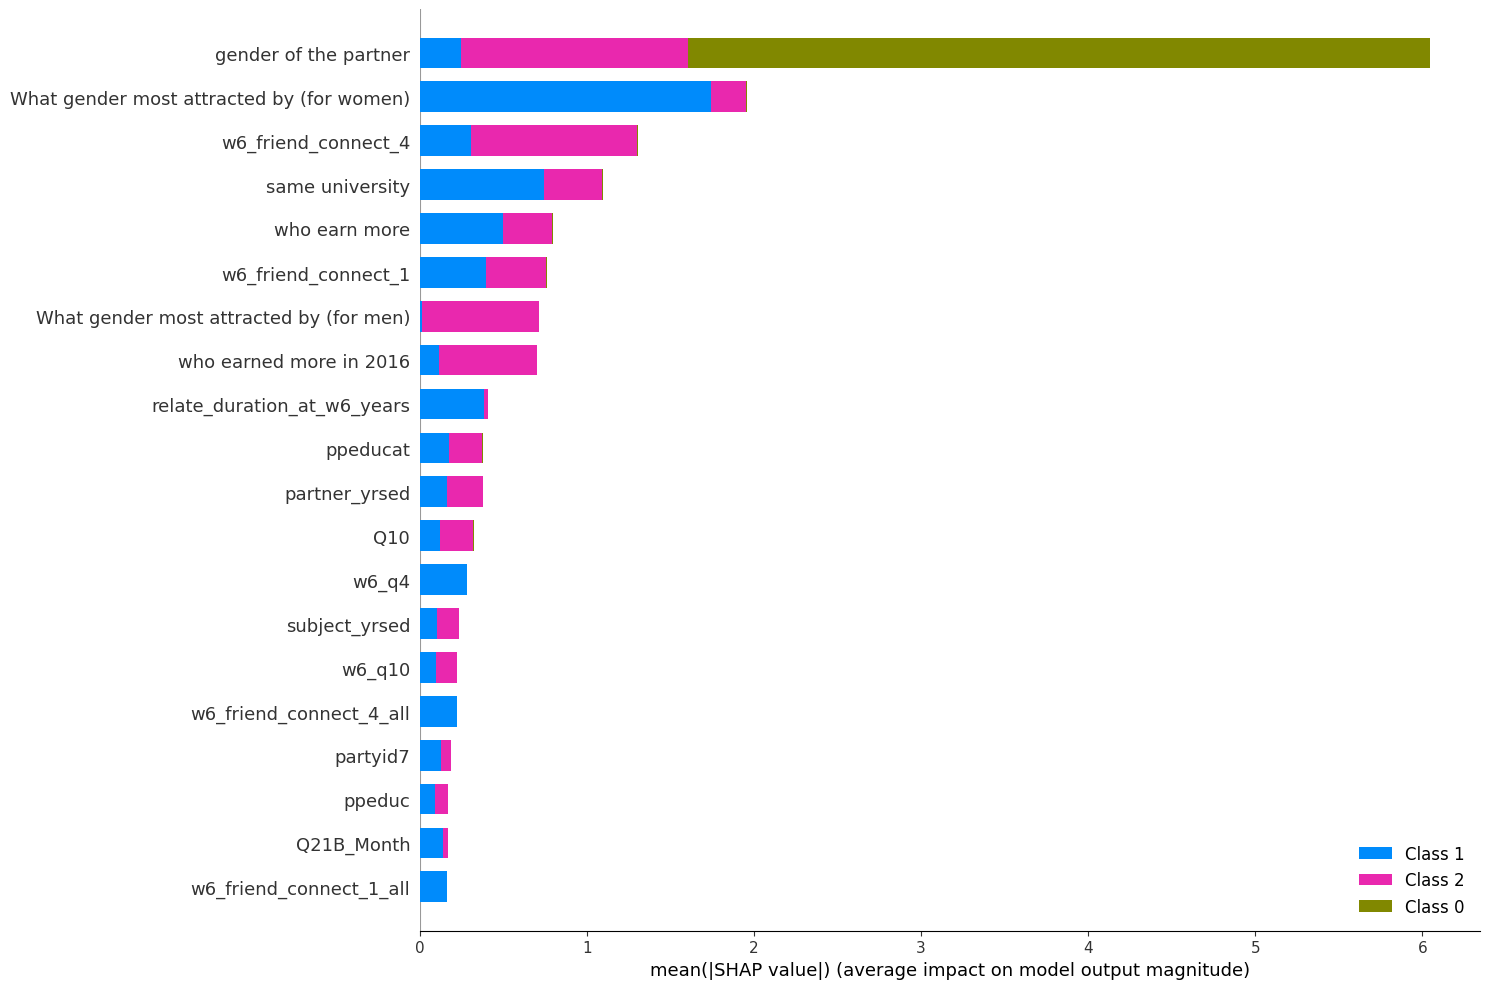

In [ ]:
clf_kp.fit(X, y)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(X)
shap.summary_plot(shap_values_kp, X, plot_type="bar", plot_size=(15, 10))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf=RandomForestClassifier()

rf.fit(X_train,y_train)
print(accuracy_score(y_test, rf.predict(X_test)))

important_features_dict = {}
for idx, val in enumerate(rf.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict,
                                 key=important_features_dict.get,
                                 reverse=True)

print(f'5 most important features: {important_features_list[:10]}')


0.9173789173789174
5 most important features: [24, 25, 161, 10, 219, 39, 120, 29, 48, 16]


In [ ]:
X_train.iloc[:, [5, 35, 22, 34, 218]]

,S1,Q21D_Month,Q17A,Q21D_Year,partnership_status
2366,0,0,0,0,0
1092,0,0,0,0,3
2295,1,5,1,62,1
2429,1,5,3,28,1
1629,0,0,0,0,3
...,...,...,...,...,...
1754,0,0,0,0,0
585,0,0,0,0,0
3498,1,2,1,14,1
857,0,0,0,0,3


In [ ]:
my_r = combinedDfH.corr(method="spearman")
print(my_r)

                         qflag  duration  speed_flag  consent      xlgb  \
qflag                 1.000000  0.041520    0.926582      NaN  0.066301   
duration              0.041520  1.000000    0.048782      NaN  0.024154   
speed_flag            0.926582  0.048782    1.000000      NaN  0.063286   
consent                    NaN       NaN         NaN      NaN       NaN   
xlgb                  0.066301  0.024154    0.063286      NaN  1.000000   
...                        ...       ...         ...      ...       ...   
subject_mother_yrsed  0.138443  0.041438    0.123675      NaN  0.061313   
partner_yrsed         0.290312  0.024206    0.270071      NaN -0.004616   
subject_yrsed         0.031479  0.014453    0.028972      NaN  0.004375   
age_bin              -0.050795  0.071307   -0.048604      NaN  0.069938   
cluster_predicted    -0.281726 -0.024281   -0.257934      NaN  0.106739   

                            S1  do you see someone?        S3  DOV_Branch  \
qflag                -

# TRY MCA Method

In [409]:
import prince

mca_cols = bank_cust.columns

# instantiate MCA class
mca = prince.MCA(n_components = 3)

# get principal components
mca = mca.fit(bank_cust[mca_cols])

mca.row_coordinates(bank_cust)

,0,1,2
0,3.598408,0.667708,-3.373189
1,2.179264,-1.822737,0.820119
2,2.071716,-1.722947,0.690416
3,3.470698,0.636467,-3.048950
4,2.200237,-1.903647,0.832834
...,...,...,...
3505,-0.192563,0.024987,0.000663
3506,-0.179090,0.046319,-0.019785
3507,-0.191042,0.021387,-0.005061
3508,-0.186269,0.033121,-0.008842


## Apply clustering method

In [410]:
df_mca = mca.row_coordinates(bank_cust)

cost = []
for num_clusters in list(range(1,10)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 10, verbose=1)
    kmode.fit_predict(df_mca)
    cost.append(kmode.cost_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 10527.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 10524.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 10521.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 10518.0
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100,

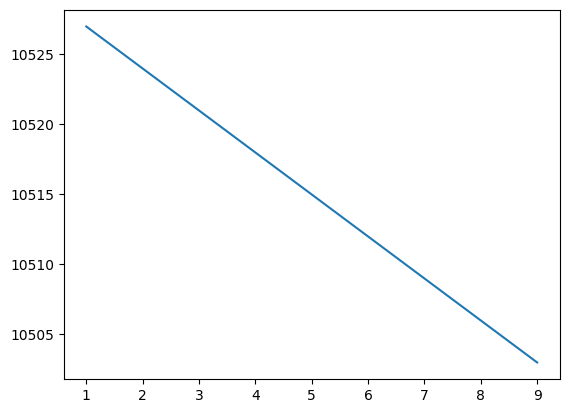

In [411]:
y = np.array([i for i in range(1,10,1)])
plt.plot(y,cost)